In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from threadpoolctl import threadpool_limits
threadpool_limits(limits=4) # set number of threads

from clima import AdiabatClimate

In [2]:
# initialize with the following three files. Check out the species.yaml and settings.yaml files
# they are heavily commented to show all possible options.

species_file = '../templates/runaway_greenhouse/species.yaml'
settings_file = '../templates/runaway_greenhouse/settings.yaml'
star_file = '../templates/ModernEarth/Sun_Now.txt'

c = AdiabatClimate(species_file, 
                   settings_file, 
                   star_file)

The object `c` is a python wrapper to the Fortran derived type `AdiabatClimate` in `src/adiabat/clima_adiabat.f90`. The class has several different methods, which I will illustrate below.

## `make_profile`

In [3]:
print(c.species_names)

['H2O', 'CO2', 'N2']


In [4]:
# partial pressures of H2O, CO2, and N2 in dynes/cm2.
# Order is the same as c.species_names. Here I'm doing 10 bars of CO2, do illustrate 
# CO2 condensation.
P_i = np.array([260.0e6, 10*1.0e6, 1.0e6])
T_surf = 280 # surface temperature (K)

c.P_top = 1.0e-2 # pressure of top of the atmosphere (dynes/cm^2). Default is 1.0e-2
c.T_trop = 150 # tropopause temperature (K). Default is 180
c.RH = np.array([1.0,1.0,1.0]) # Relative humidity of each species. default is 1.0

# Integrates a multispecies pseudoadiabat upward following
# Equation (1) in Graham et al. 2021 (doi.org/10.3847/PSJ/ac214c)
c.make_profile(T_surf, P_i)

The object `c` now has attributes that describe the atmosphere
- `c.P`, pressures in atmospheric layers (dynes/cm^2)
- `c.T`, temperature in atmospheric layers (K)
- `c.f_i`, mixing ratios of all species in atmospheric layers (2-D array)
- `c.z`, altitude of center of atmospheric layers (cm)
- `c.dz`, thickness of each atmospheric layers (cm)

Here are some illustrative plots:

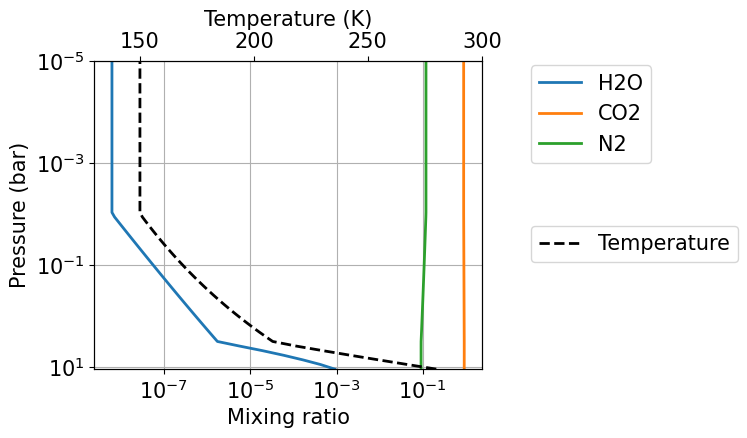

In [5]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i], c.P/1e6, lw=2, label=c.species_names[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(c.P[0]/1e6,1e-5)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.grid()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Mixing ratio')

ax1 = ax.twiny()

ax1.plot(c.T, c.P/1e6, 'k--', lw=2, label='Temperature')
ax1.set_xlabel('Temperature (K)')
ax1.legend(ncol=1,bbox_to_anchor=(1.1, .5), loc='upper left')
ax1.set_xlim(130,300)

plt.show()

In [6]:
# N_surface contains the surface reservoir of volatiles in mol/cm^2.
# Here I assume that only gases that are saturated at surface have a surface reservoir.
# It is calculated as N_surface = (P_gas_total - P_saturation)/(molar_mass*surface_gravity)
print(c.N_surface)

[14696.15911254     0.             0.        ]


## `make_column`

In [7]:
# very similar to make_profile, Except make_column takes in column abundances in mol/cm^2.

N_i = np.array([15.0e3, 400e-6*23.0, 1.0*36.0]) # mol/cm^2
c.make_column(T_surf, N_i)

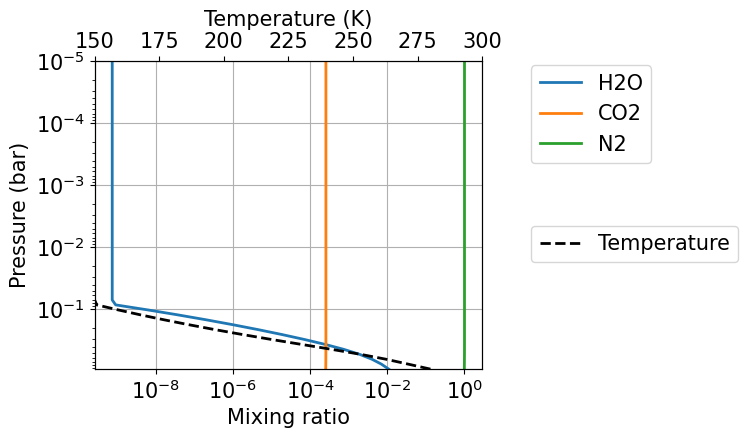

In [8]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i], c.P/1e6, lw=2, label=c.species_names[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(c.P[0]/1e6,1e-5)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.grid()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Mixing ratio')

ax1 = ax.twiny()

ax1.plot(c.T, c.P/1e6, 'k--', lw=2, label='Temperature')
ax1.set_xlabel('Temperature (K)')
ax1.legend(ncol=1,bbox_to_anchor=(1.1, .5), loc='upper left')
ax1.set_xlim(150,300)

plt.show()

In [16]:
# here you can see that the total reservoir of H2O (surface + atmosphere) 
# equals our input value (with some error)
print(c.N_surface[0] + np.sum(c.densities[:,0]*c.dz)/6.02214076e23)

15000.000000292375


## `TOA_fluxes`

In [17]:
# `TOA_fluxes` first calls `make_profile`, then does radiative transfer on the atmosphere, and returns
# the incomming solar radiation (ISR) and outgoing longwave radiation (OLR) in mW/m^2
P_i = np.array([260.0e6, 400.0e-6*1.0e6, 1.0e6])
T_surf = 280
c.T_trop = 215
c.RH = np.array([1.0,1.0,1.0])

ISR, OLR = c.TOA_fluxes(T_surf, P_i)
print(ISR) # mW/m^2
print(OLR) # mW/m^2

253058.85911994014
247229.2863160162


In [18]:
# Lets check the runway greenhouse limit
P_i = np.array([200.0e6, 1e-6*1.0e6, 1.0e6])
TT = np.linspace(216,2000,100)
OLR = np.empty(TT.shape[0])
ISR = np.empty(TT.shape[0])
for i,T in enumerate(TT):
    ISR_, OLR_ = c.TOA_fluxes(T, P_i)
    OLR[i] = OLR_/1.0e3
    ISR[i] = ISR_/1.0e3

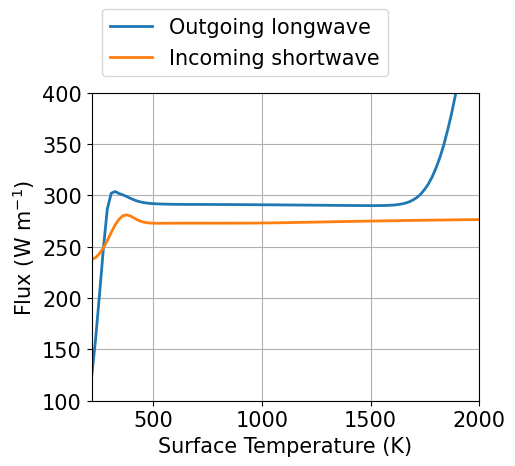

In [19]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

ax.plot(TT,OLR,lw=2, label='Outgoing longwave')
ax.plot(TT,ISR,lw=2, label='Incoming shortwave')

ax.grid()
ax.set_ylabel('Flux (W m$^{-1}$)')
ax.set_xlabel('Surface Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_ylim(100,400)
ax.set_xlim(min(TT),max(TT))

plt.show()

In [20]:
# runway greenhouse limit is:
ISR, OLR = c.TOA_fluxes(500, P_i)
print("Runway greenhouse limit =",OLR/1e3,'W/m^2')

Runway greenhouse limit = 291.9549847279186 W/m^2


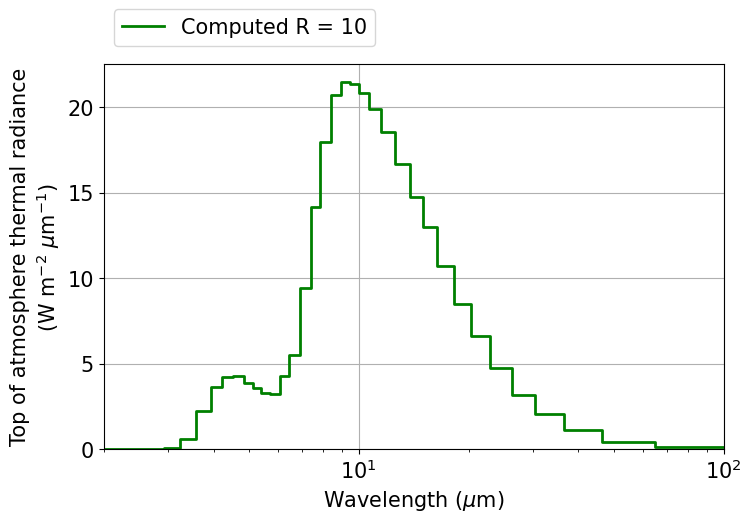

In [21]:
# you can also look at the radiation as a function of wavelength.
# here we consider a pure H2O atmosphere. 
# This roughly reproduces Fig 1c, 300 K case in Goldblatt et al. 2013

P_i = np.array([270.0e6, 1e-20*1.0e6, 1e-20*1.0e6])
T = 300
ISR, OLR = c.TOA_fluxes(500, P_i)

freq = c.rad.ir.freq # Hz
freq_av = (freq[1:]+freq[:-1])/2 # Hz
wv_av = 1e6*const.c/freq_av # microns
# c.rad.wrk_ir.fup_a is mW/m^2/Hz. Here I convert to W/m^2/um
F = 1e-3*c.rad.wrk_ir.fup_a[-1,:]*(freq_av/(wv_av))

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[8,5])

ax.plot(wv_av, F, drawstyle='steps-mid',lw=2,c='g',label='Computed R = 10')

ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')
ax.set_xscale("log")
ax.set_xlim(2,100)
ax.set_ylim(0,ax.get_ylim()[1])
ax.grid()

ax.set_ylabel('Top of atmosphere thermal radiance\n(W m$^{-2}$ $\mu$m$^{-1}$)')
ax.set_xlabel('Wavelength ($\mu$m)')

plt.show()

## `surface_temperature`

In [22]:
# `surface_temperature` calls `make_profile` and does radiative transfer 
# several times to solve for an equilibriumm climate state

P_i = np.array([260.0e6, 400e-6*1.0e6, 1.0e6])
T_surf = c.surface_temperature(P_i, T_guess = 280) # optionally include a guess for T_surf
print(T_surf)

283.85420541510285


## `TOA_fluxes_column` and `surface_temperature_column`


In [23]:
# There are also routines which take in columnn abundances (mol/cm2) instead of pressures
# to compute the fluxes at the top of the atmosphere, and the surface temperature

N_i = np.array([15.0e3, 400e-6*23.0, 1.0*36.0]) # mol/cm^2

ISR, OLR = c.TOA_fluxes_column(280, N_i)
print('OLR (W/m^2) =',OLR/1e3)

T_surf = c.surface_temperature_column(N_i)
print('T_surf (K) =',T_surf)

OLR (W/m^2) = 250.89626703295792
T_surf (K) = 282.2146562320749


## Other

There is also `to_regular_grid`. This routine re-grids the atmosphere so that is regular in altitude. Additionally there is `out2atmosphere_txt`, which outputs the atmophere to a file

In [24]:
T_surf = c.surface_temperature_column(N_i)
c.out2atmosphere_txt('atmosphere.txt',eddy=np.zeros(len(c.T)),overwrite=True)